In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import sys
sys.path.append('../src/fnc')

import LMPC
import SysModel
from Track import Map
import Utilities
import pwa_cluster as pwac

import matplotlib.pyplot as plt

In [4]:
trackMap = Map(0.8) 
dt = 0.1
n = 6; d = 2
state_names = ['vx', 'vy', 'wz', 'epsi', 's', 'ey']

n_data = 500

In [5]:
def generate_random_input():
    # x = [vx, vy, wz, epsi, s, ey]
    # u = [delta, a]
    x = np.random.uniform(size=[n]) * np.array([3, 1, 1, 1, trackMap.TrackLength, 2*0.8]) + np.array([0, 0, 0, 0, 0, -0.8])
    u = np.random.uniform(size=[d]) * np.array([1, 2]) + np.array([-0.5, -1])
    return x, u

def get_z_y_pair():
    x, u = generate_random_input()
    x_glob = trackMap.get_global_state(x)
    x_next, x_glob_next = SysModel._DynModel(x, x_glob, u, dt, trackMap.PointAndTangent)
    return np.hstack([x,u]), x_next


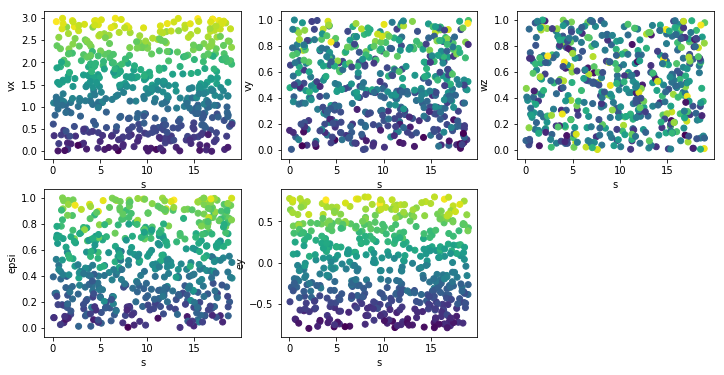

In [10]:
zs = []; ys = []
for i in range(n_data):
    z, y = get_z_y_pair()
    zs.append(z); ys.append(y)

zs = np.array(zs)
ys = np.array(ys)
    
plt.figure(figsize=[12,6])
for i in range(n-1):
    plt.subplot(2, 3, i+1)
    ind = i if i < 4 else 5
    plt.scatter(zs[:,4], zs[:,ind], c=[ys[:,ind]])
    plt.xlabel(state_names[4]); plt.ylabel(state_names[ind])

In [16]:
best_clustering = pwac.ClusterPWA.from_num_clusters(zs, ys, 4)

In [17]:
best_clustering.fit_clusters()

In [22]:
nc_list = [4]
best_clustering, ind_perm = pwac.select_nc_cross_validation(nc_list, zs, ys, verbose=True, z_cutoff=n)


===================== Fitting model with Nc= 4 ====================
assigning datapoints to clusters
updating models
centroid movement 3.30134627525
assigning datapoints to clusters
updating models
centroid movement 0.632430989961
assigning datapoints to clusters
updating models
centroid movement 0.272048214227
assigning datapoints to clusters
updating models
centroid movement 0.133566482063
assigning datapoints to clusters
updating models
centroid movement 0.0650785675901
assigning datapoints to clusters
updating models
centroid movement 0.0889802929781
assigning datapoints to clusters
updating models
centroid movement 0.0430774609421
assigning datapoints to clusters
updating models
centroid movement 0.0
done
avg train error: 0.025103846956
avg test error: [ 0.01377313  0.02447914  0.20807268  0.08827326  0.01478689  0.02321129
  0.02511222  0.02577892  0.05296395  0.01583162  0.10403634  0.04221765
  0.0305028   0.01910175  0.0350966   0.19420117  0.0378314   0.01467515
  0.01211234 

In [27]:
best_clustering.Nc

4

In [23]:
best_clustering.determine_polytopic_regions(verbose=True)

----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 24000, CG tol ~ 1/iter^(2.00)
eps = 1.00e-03, alpha = 1.50, max_iters = 2500, normalize = 1, scale = 1.00
Variables n = 1528, constraints m = 3000
Cones:	linear vars: 3000
Setup time: 2.59e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.48e+00  1.54e+00  8.55e-01 -2.54e+00  3.36e+00  0.00e+00  1.96e-02 
   100| 7.47e-02  5.71e-02  2.21e-02  2.03e-01  2.34e-01  2.48e-16  1.15e-01 
   200| 5.19e-02  3.59e-02  2.49e-02  6.05e-02  8.92e-02  2.47e-16  2.62e-01 
   300| 5.55e-02  5.76e-02  6.04e-03  4.05e-02  4.71e-02 

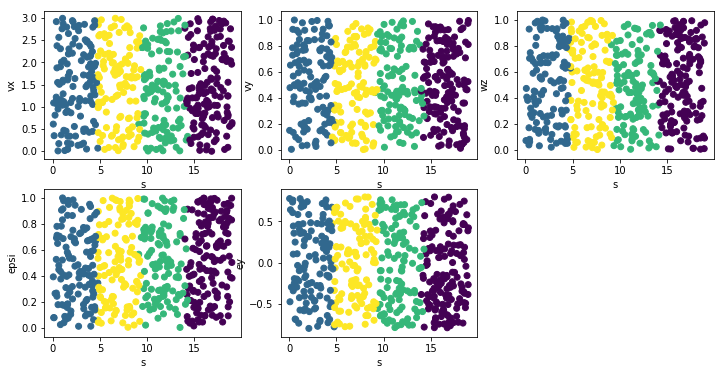

In [29]:
plt.figure(figsize=[12,6])
for i in range(n-1):
    plt.subplot(2, 3, i+1)
    ind = i if i < 4 else 5
    plt.scatter(best_clustering.zs[:,4], best_clustering.zs[:,ind], c=best_clustering.cluster_labels)
    plt.xlabel(state_names[4]); plt.ylabel(state_names[ind])

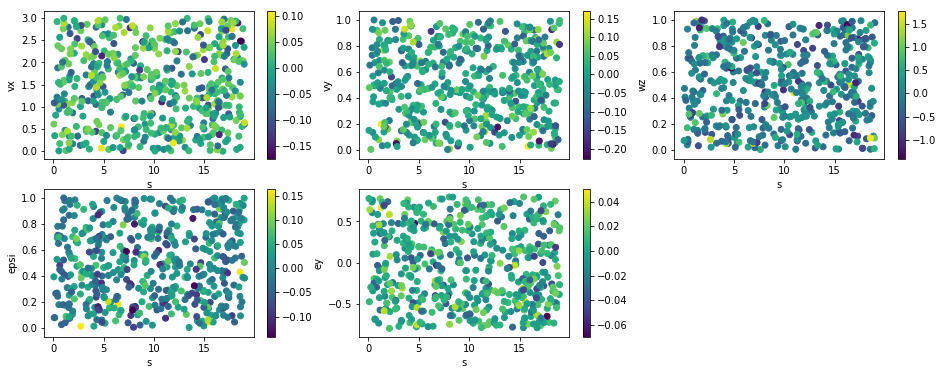

In [39]:
yhats = []
for z,y in zip(best_clustering.zs, best_clustering.ys):
    yhats.append(best_clustering.get_prediction(z))
yhats = np.array(yhats)

plt.figure(figsize=[16,6])
for i in range(n-1):
    plt.subplot(2, 3, i+1)
    ind = i if i < 4 else 5
    plt.scatter(best_clustering.zs[:,4], best_clustering.zs[:,ind], c=(best_clustering.ys[:,ind]-yhats[:,ind]))
    plt.xlabel(state_names[4]); plt.ylabel(state_names[ind]); plt.colorbar()

In [31]:
# self.clustering = pwac.ClusterPWA.from_labels(zs, ys, 
#                                data['labels'], z_cutoff=self.n)
# self.clustering.region_fns = data['region_fns']
np.savez('pwa_model_'+str(best_clustering.Nc), labels=best_clustering.cluster_labels, region_fns=best_clustering.region_fns, 
         thetas=best_clustering.thetas, zs=best_clustering.zs, ys=best_clustering.ys)

In [8]:
print(x_next)
print(x_glob_next)

[  0.40271081  -0.0565205   -0.51047363   0.06231556  11.55229491
  -0.59633254]
[ 0.40362651 -0.05722567 -0.51032248  3.10423143 -2.42395266 -3.05482882]
